In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam


from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
start = '2016-01-01'
end = '2021-01-01'
GSPC = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
GSPC.isnull().sum().sort_values(ascending = False)

              Adj Close
Date                   
2016-01-04  2012.660034
2016-01-05  2016.709961
2016-01-06  1990.260010
2016-01-07  1943.089966
2016-01-08  1922.030029
...                 ...
2020-12-24  3703.060059
2020-12-28  3735.360107
2020-12-29  3727.040039
2020-12-30  3732.040039
2020-12-31  3756.070068

[1259 rows x 1 columns]


Adj Close    0
dtype: int64

In [111]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [78]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [83]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [115]:
GSPC_pure=create_pure(GSPC)

In [80]:
GSPC_noisy

,0,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
0,2012.660034,2016.709961,1990.260010,1943.089966,1922.030029,1923.670044,1938.680054,1890.280029,1921.839966,1880.329956,...,2762.590088,2767.320068,2749.760010,2754.879883,2717.070068,2723.060059,2699.629883,2716.310059,2718.370117,2726.709961
0,1881.329956,1859.329956,1868.989990,1906.900024,1877.079956,1903.630005,1882.949951,1893.359985,1940.239990,1939.380005,...,2713.219971,2736.610107,2759.820068,2784.169922,2793.840088,2774.020020,2798.290039,2801.310059,2798.429932,2809.550049
0,1903.030029,1912.530029,1915.449951,1880.050049,1853.439941,1852.209961,1851.859985,1829.079956,1864.780029,1895.579956,...,2815.620117,2804.489990,2801.830078,2806.979980,2820.399902,2846.070068,2837.439941,2818.820068,2802.600098,2816.290039
0,1926.819946,1917.829956,1917.780029,1945.500000,1921.270020,1929.800049,1951.699951,1948.050049,1932.229980,1978.349976,...,2813.360107,2827.219971,2840.350098,2850.399902,2858.449951,2857.699951,2853.580078,2833.280029,2821.929932,2839.959961
0,1986.449951,1993.400024,1999.989990,2001.760010,1979.260010,1989.260010,1989.569946,2022.189941,2019.640015,2015.930054,...,2818.370117,2840.689941,2850.129883,2857.050049,2862.959961,2861.820068,2856.979980,2874.689941,2896.739990,2897.520020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2634.560059,2639.399902,2666.939941,2669.909912,2648.050049,2654.800049,2635.669922,2629.729980,2663.419922,2672.629883,...,3419.439941,3446.830078,3477.139893,3534.219971,3511.929932,3488.669922,3483.340088,3483.810059,3426.919922,3443.120117
0,2671.919922,2697.790039,2723.070068,2727.719971,2730.129883,2711.449951,2722.459961,2720.129883,2712.969971,2733.010010,...,3435.560059,3453.489990,3465.389893,3400.969971,3390.679932,3271.030029,3310.110107,3269.959961,3310.239990,3369.159912
0,2724.439941,2733.290039,2727.760010,2721.330078,2689.860107,2724.010010,2705.270020,2734.620117,2746.870117,2748.800049,...,3443.439941,3510.449951,3509.439941,3550.500000,3545.530029,3572.659912,3537.010010,3585.149902,3626.909912,3609.530029
0,2772.350098,2770.370117,2779.030029,2782.000000,2786.850098,2775.629883,2782.489990,2779.659912,2773.750000,2762.590088,...,3567.790039,3581.870117,3557.540039,3577.590088,3635.409912,3629.649902,3638.350098,3621.629883,3662.449951,3669.010010


In [116]:
GSPC_pure

,0,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
0,1982.916372,1986.895896,1981.332859,1968.074815,1949.906348,1930.285377,1915.363144,1909.793099,1906.790554,1891.628363,...,2766.564057,2762.053480,2757.019723,2745.472495,2727.744309,2713.033168,2707.079488,2711.823531,2721.590848,2726.695627
0,1880.060396,1877.852774,1883.675323,1890.651117,1891.569170,1889.846766,1896.435384,1909.820492,1922.023736,1925.807960,...,2722.167774,2733.698026,2751.860579,2769.179422,2779.859908,2785.264333,2789.938149,2796.853174,2803.734049,2805.915313
0,1904.581365,1916.165635,1910.890424,1889.750023,1863.269067,1843.282465,1837.113860,1845.100176,1864.505777,1888.954895,...,2809.022010,2810.318249,2813.024361,2817.486306,2822.394393,2826.025018,2827.188097,2826.827626,2826.421123,2827.063776
0,1932.786411,1929.788365,1929.965439,1932.752746,1935.435861,1935.488607,1935.100756,1937.753854,1947.229259,1965.555531,...,2817.936899,2827.445429,2836.656313,2844.024799,2848.006138,2847.651217,2844.393487,2840.262038,2837.285959,2836.967246
0,1999.310817,1999.102071,1997.852258,1993.355519,1985.630105,1983.863089,1996.069554,2012.946727,2024.544995,2030.988511,...,2829.886184,2832.947049,2838.052800,2845.202536,2853.645695,2862.454967,2870.745703,2877.674211,2882.517980,2884.700172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2645.362803,2650.623386,2657.574094,2660.946616,2656.267048,2645.932572,2639.926356,2641.663665,2651.017796,2663.907247,...,3400.127513,3443.886641,3491.297452,3519.870275,3522.187572,3507.308478,3485.531252,3461.468535,3449.688107,3459.652314
0,2687.571977,2698.549432,2709.232817,2717.175185,2720.932651,2719.770542,2715.776562,2714.456586,2718.326446,2726.934572,...,3443.753439,3454.184766,3450.723290,3422.155185,3363.673340,3300.876095,3280.155065,3299.499580,3323.262524,3340.993870
0,2711.410928,2712.022956,2710.253603,2707.788312,2707.007255,2709.829686,2716.304311,2726.219515,2739.794424,2754.456139,...,3450.198618,3493.933625,3521.065964,3541.719200,3555.909233,3556.007483,3561.495977,3580.497165,3594.551503,3586.196073
0,2777.875993,2777.374063,2778.188392,2779.660372,2780.843178,2780.866008,2779.242130,2775.935406,2771.342637,2766.451466,...,3587.914395,3564.740677,3563.390512,3589.779186,3625.500426,3638.052733,3629.288769,3633.221462,3649.304829,3655.888880


In [151]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(63, 629)
(63, 629)


In [160]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [158]:
keras.backend.clear_session()

In [161]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(1,kernel_size=1,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 128)         512       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          24640     
                                                                 
 conv1d_7 (Conv1D)           (None, None, 64)          12352     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         24704     
                                                                 
 conv1d_9 (Conv1D)           (None, None, 1)           129       
                                                                 
Total params: 62,337
Trainable params: 62,337
Non-trainable params: 0
_________________________________________________________________


In [162]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
2/2 [==============================] - 1s 171ms/step - loss: 0.0643 - mae: 0.2136 - val_loss: 0.0340 - val_mae: 0.1466
Epoch 2/400
2/2 [==============================] - 0s 55ms/step - loss: 0.0604 - mae: 0.2071 - val_loss: 0.0319 - val_mae: 0.1441
Epoch 3/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0566 - mae: 0.2005 - val_loss: 0.0298 - val_mae: 0.1422
Epoch 4/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0520 - mae: 0.1916 - val_loss: 0.0289 - val_mae: 0.1434
Epoch 5/400
2/2 [==============================] - 0s 55ms/step - loss: 0.0479 - mae: 0.1828 - val_loss: 0.0284 - val_mae: 0.1439
Epoch 6/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0448 - mae: 0.1755 - val_loss: 0.0261 - val_mae: 0.1379
Epoch 7/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0409 - mae: 0.1673 - val_loss: 0.0216 - val_mae: 0.1237
Epoch 8/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0360 - mae: 0.1

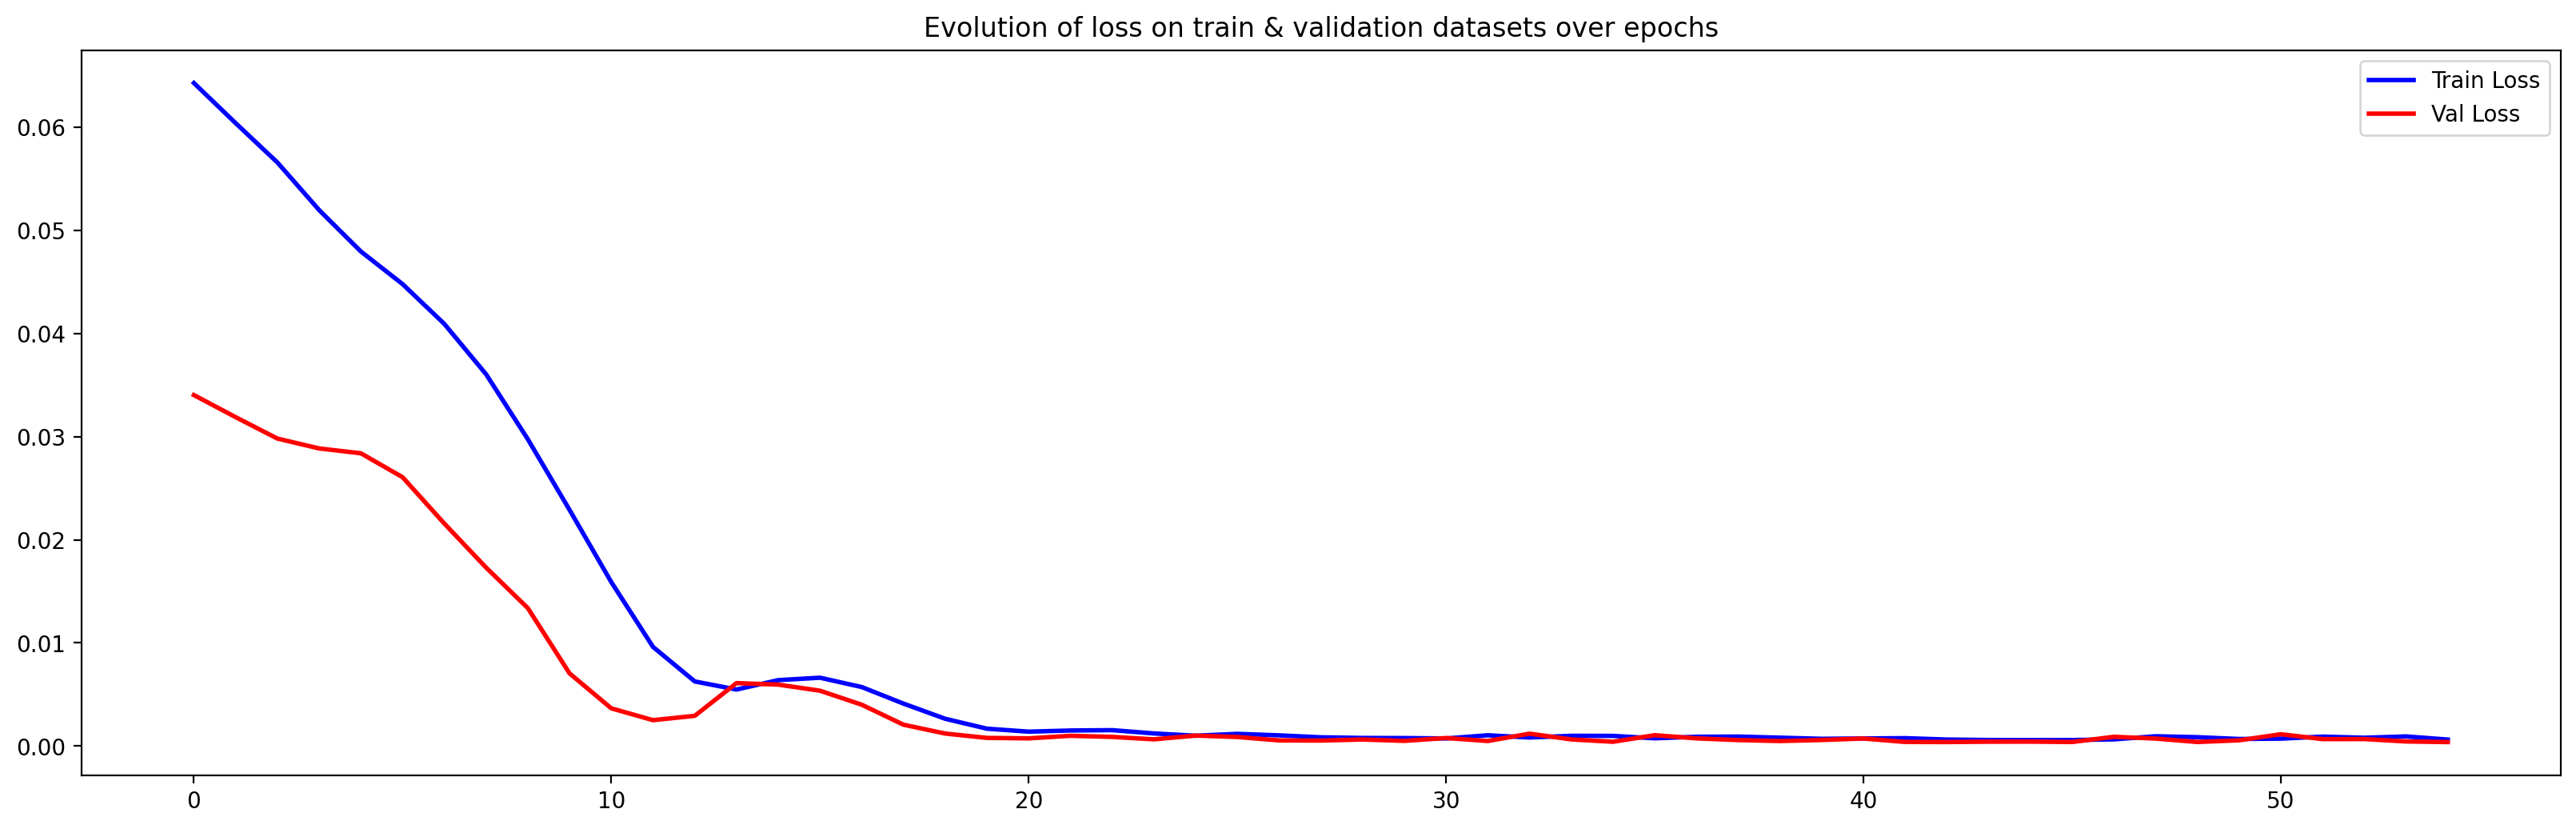

In [163]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [226]:
start = '2020-01-01'
end = '2022-01-01'
GSPC_test = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

,Adj Close
Date,
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049
...,...
2021-12-27,4791.189941
2021-12-28,4786.350098
2021-12-29,4793.060059


1/1 [==============================] - 0s 14ms/step


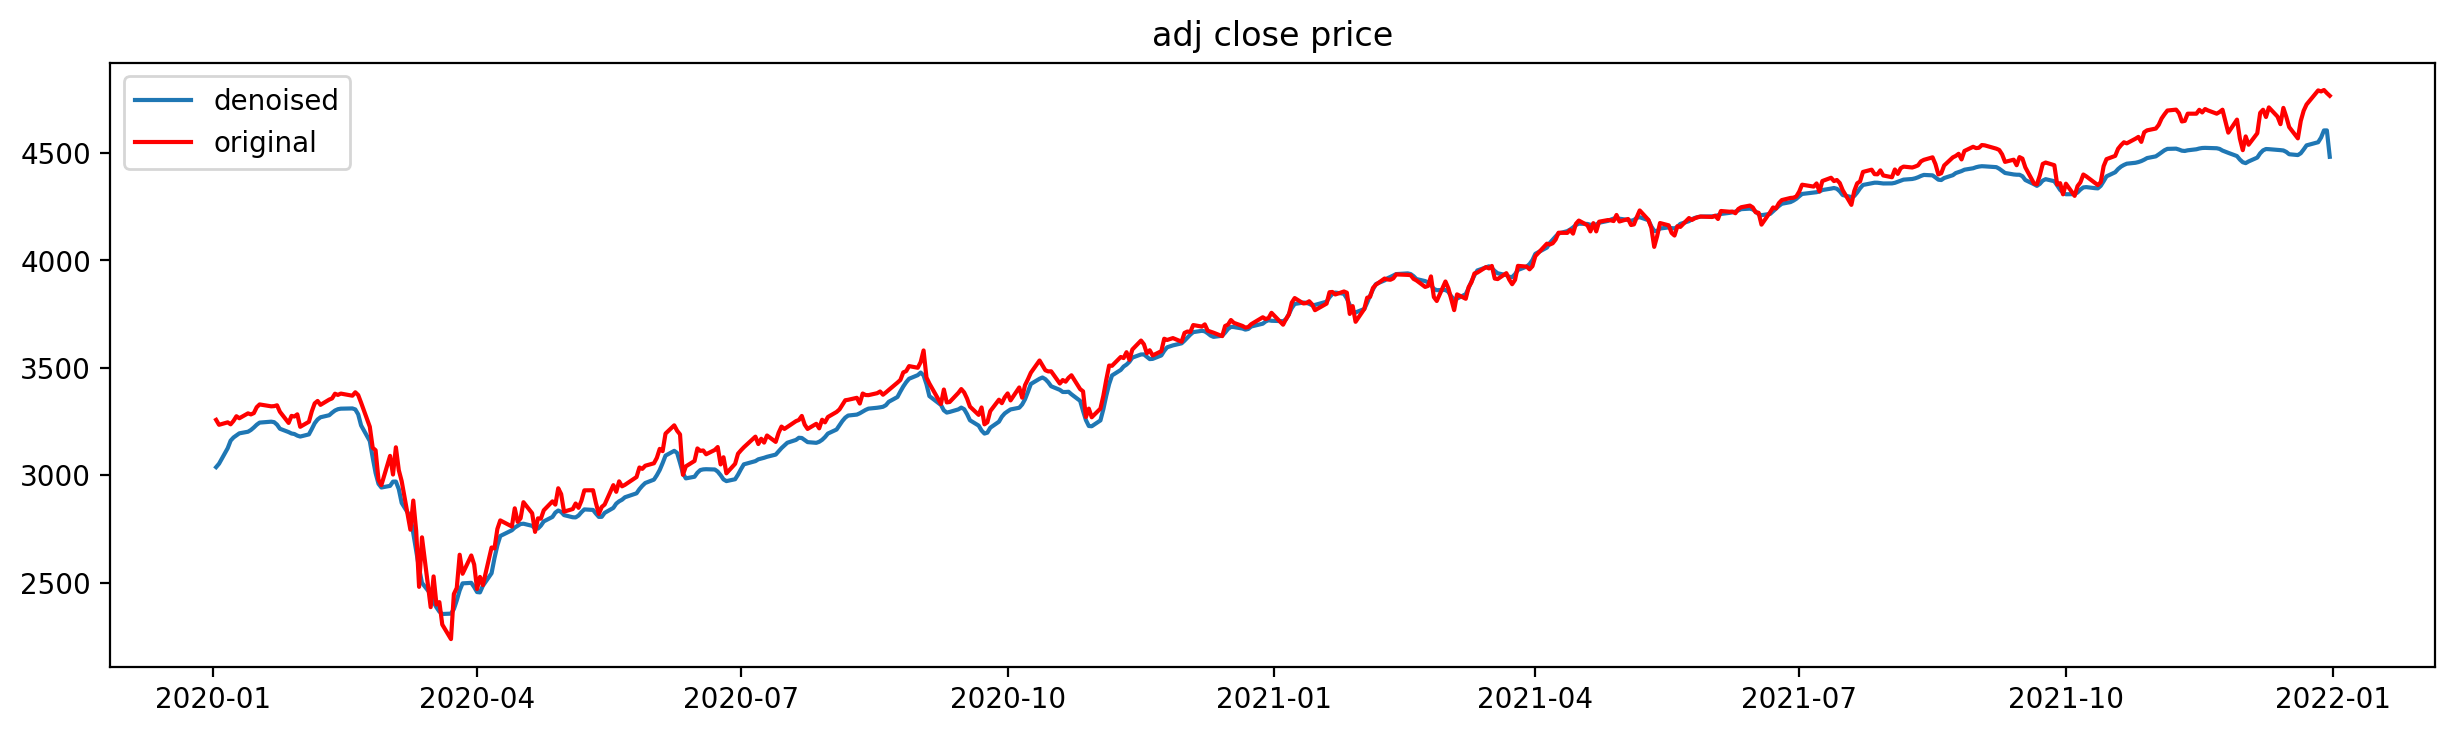

In [227]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

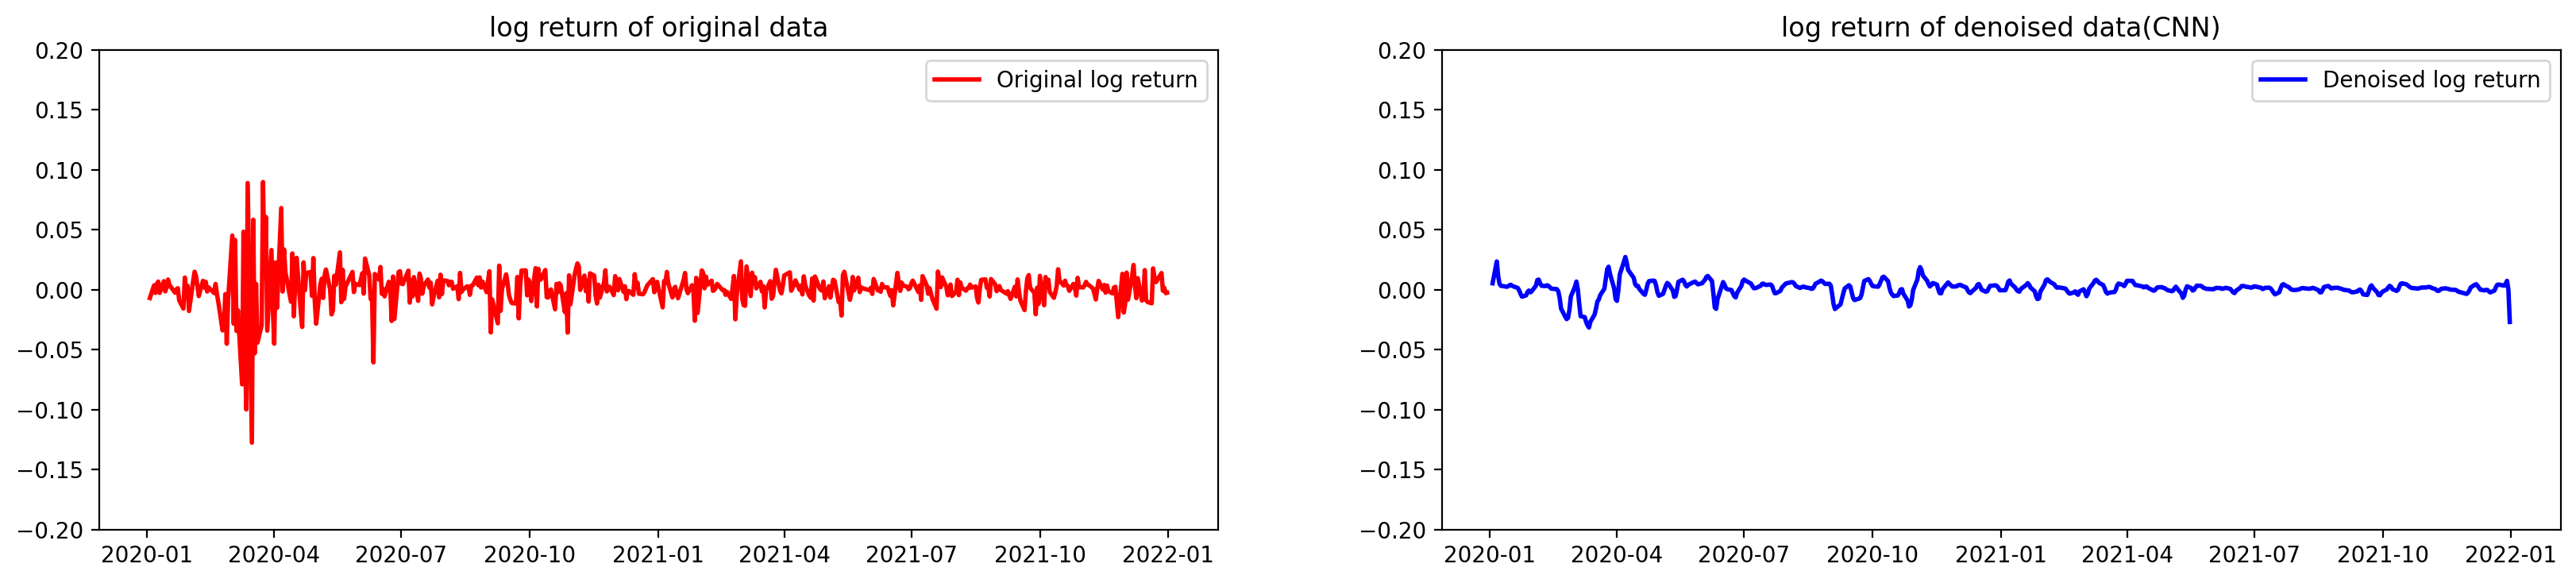

In [228]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [229]:
def svmf1(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [230]:
original_svm,denoised_svm=svmf1(GSPC_test_n,pure_mm_cnn,long_predict=1)

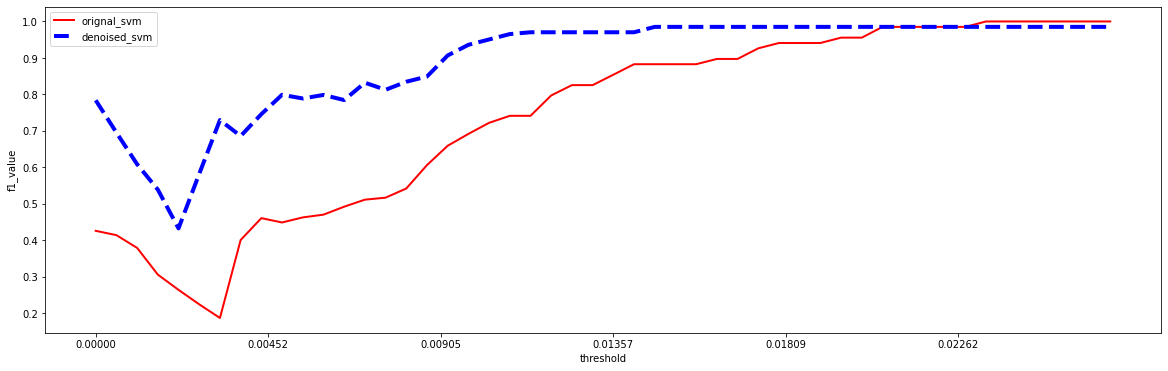

In [231]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [233]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [234]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=10)

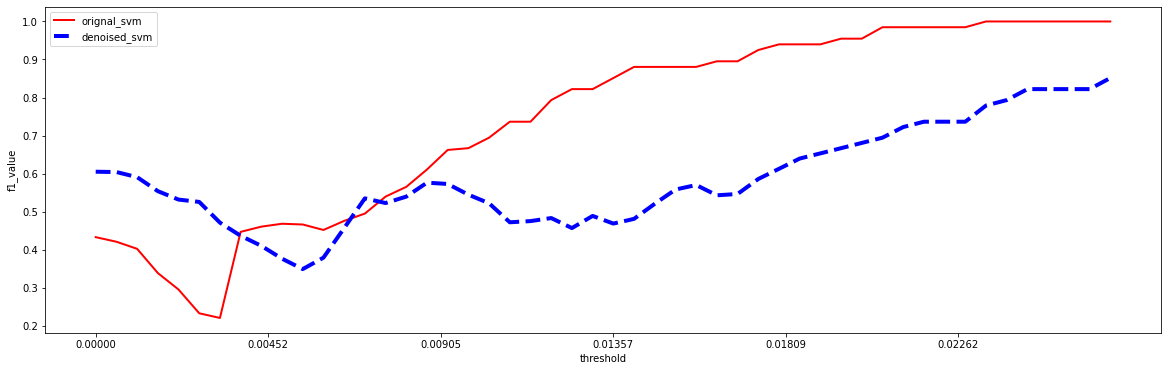

In [235]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()